In [1]:
import shap
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lime
from tqdm import tqdm
from classification_utils import *
import tensorflow as tf

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-16 12:52:40.891421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load dataset

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

name lang  bot           created_at  statuses_count  \
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42              76   
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32              54   
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56              53   
466124818     Carletto Focia   it    1  2017-01-18 02:49:18              50   
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21            7085   

            avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
2353593986   62.340909          14.015152    0.000000        0.272727   
2358850842   69.082645          15.041322    0.000000        0.338843   
137959629    65.340909          14.694444    0.000000        0.000000   
466124818    86.944871          18.689463    0.022331        0.006281   
2571493866   72.311246          14.582073    0.000825        0.506461   

            hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.098485               0.0              0.0   
2358850842        0.024793               0.0              0.0   
137959629         0.000000               0.0              0.0   
466124818         0.072575               0.0              0.0   
2571493866        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  
2353593986            0.037879           0.190903  
2358850842            0.024793           0.155495  
137959629             0.000000           0.000000  
466124818             0.826239          13.034008  
2571493866            0.016772           0.142619

In [4]:
#a descrption of the dataset
data.describe()

bot  statuses_count    avg_length  avg_special_chars  \
count  11508.000000    11508.000000  11508.000000       11508.000000   
mean       0.531456     5148.794751     67.100135          15.045892   
std        0.499031    18496.606420     12.755296           2.454106   
min        0.000000        0.000000     32.500000           9.644166   
25%        0.000000       53.000000     59.686796          13.553296   
50%        1.000000       57.000000     65.340909          14.694444   
75%        1.000000     2041.000000     74.254999          16.772205   
max        1.000000   399555.000000    104.449541          22.000000   

         urls_ratio  mentions_ratio  hashtags_ratio  reply_count_mean  \
count  11508.000000    11508.000000    11508.000000      11508.000000   
mean       0.031045        0.329076        0.088484          0.001967   
std        0.053379        0.315589        0.070828          0.007796   
min        0.000000        0.000000        0.000000          0.000000   
25%        0.000000        0.010260        0.045455          0.000000   
50%        0.005109        0.300971        0.070423          0.000000   
75%        0.037445        0.450781        0.113295          0.000000   
max        0.287760        1.210354        0.337268          0.044444   

       reply_count_std  favorite_count_mean  favorite_count_std  \
count     11508.000000         11508.000000        11508.000000   
mean          0.023941             0.084281            0.365536   
std           0.068508             0.109621            0.408358   
min           0.000000             0.000000            0.000000   
25%           0.000000             0.017751            0.136692   
50%           0.000000             0.045752            0.230747   
75%           0.000000             0.088862            0.451218   
max           0.333767             0.529903            2.183383   

       favorite_count_entropy  retweet_count_mean  retweet_count_std  
count            11508.000000        11508.000000       11508.000000  
mean                 0.385427            1.357545          14.574041  
std                  0.390777            2.827068          23.390000  
min                  0.000000            0.000000           0.000000  
25%                  0.119116            0.010526           0.104251  
50%                  0.268594            0.043478           0.238606  
75%                  0.491767            0.949402          24.144412  
max                  1.723913           12.902439         198.461303

In [5]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


In [6]:
features = test_set.columns.to_list()

In [7]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_set)
test_X = scaler.transform(test_set)

In [8]:
with open("models_checkpoints/nn_no_lang.bin", "rb") as f:
    nn_model = pickle.load(f)

In [9]:
nn_model

MLPClassifier(hidden_layer_sizes=[16, 8], max_iter=250, momentum=0.1,
              random_state=8)

## Explain the results: SHAP

In [10]:
shap.initjs()

In [11]:
explainer = shap.KernelExplainer(nn_model.predict_proba, shap.sample(train_X, 20))

In [12]:
shap_values = explainer.shap_values(test_X[0:200])

  0%|                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  3%|█████                                                                                                                                                                  | 6/200 [00:01<00:37,  5.22it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  6%|█████████▉                                                                                                                                                            | 12/200 [00:02<00:35,  5.30it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  9%|██████████████▉                                                                                                                                                       | 18/200 [00:03<00:34,  5.26it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 12%|███████████████████▉                                                                                                                                                  | 24/200 [00:04<00:32,  5.46it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 15%|████████████████████████▉                                                                                                                                             | 30/200 [00:05<00:31,  5.47it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 18%|█████████████████████████████▉                                                                                                                                        | 36/200 [00:06<00:30,  5.44it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 21%|██████████████████████████████████▊                                                                                                                                   | 42/200 [00:07<00:30,  5.16it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 24%|███████████████████████████████████████▊                                                                                                                              | 48/200 [00:09<00:31,  4.87it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 27%|████████████████████████████████████████████▊                                                                                                                         | 54/200 [00:10<00:30,  4.80it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 30%|█████████████████████████████████████████████████▊                                                                                                                    | 60/200 [00:11<00:28,  4.91it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 33%|██████████████████████████████████████████████████████▊                                                                                                               | 66/200 [00:12<00:26,  5.12it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 72/200 [00:13<00:24,  5.24it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 78/200 [00:15<00:23,  5.25it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 84/200 [00:16<00:21,  5.28it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 90/200 [00:17<00:20,  5.25it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 96/200 [00:18<00:19,  5.35it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/200 [00:19<00:19,  4.95it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 108/200 [00:20<00:18,  5.06it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 114/200 [00:21<00:16,  5.15it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 120/200 [00:23<00:15,  5.28it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 126/200 [00:24<00:14,  5.19it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 132/200 [00:25<00:13,  4.99it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 138/200 [00:26<00:12,  5.09it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 144/200 [00:27<00:11,  4.77it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 150/200 [00:29<00:09,  5.03it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 156/200 [00:30<00:08,  4.91it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 162/200 [00:31<00:07,  5.13it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 168/200 [00:32<00:06,  4.81it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 174/200 [00:33<00:05,  4.78it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 180/200 [00:35<00:03,  5.03it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 186/200 [00:36<00:02,  5.23it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 192/200 [00:37<00:01,  4.98it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198/200 [00:38<00:00,  4.80it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0], test_X, link="logit",feature_names=features)

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1], test_X, link="logit",feature_names=features)

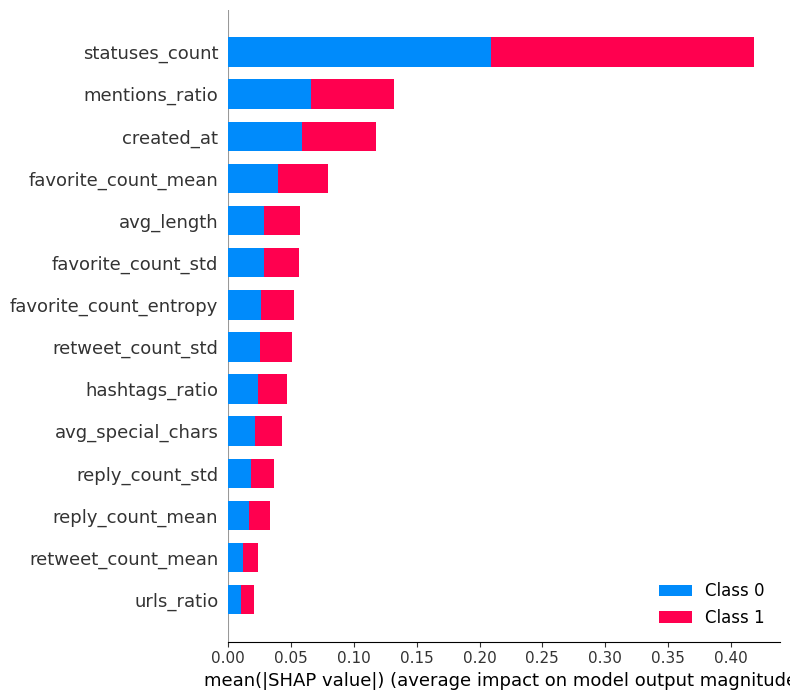

In [15]:
shap.summary_plot(shap_values, test_X[0:200], feature_names=features)

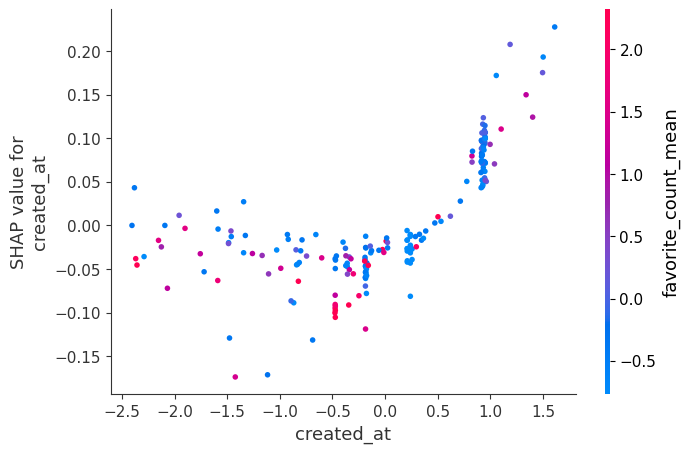

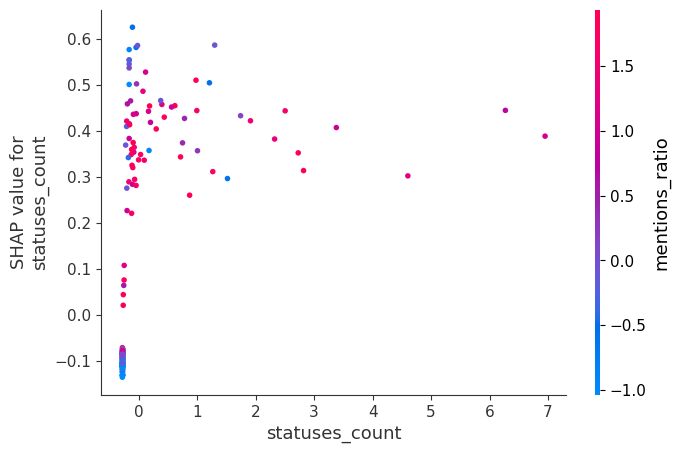

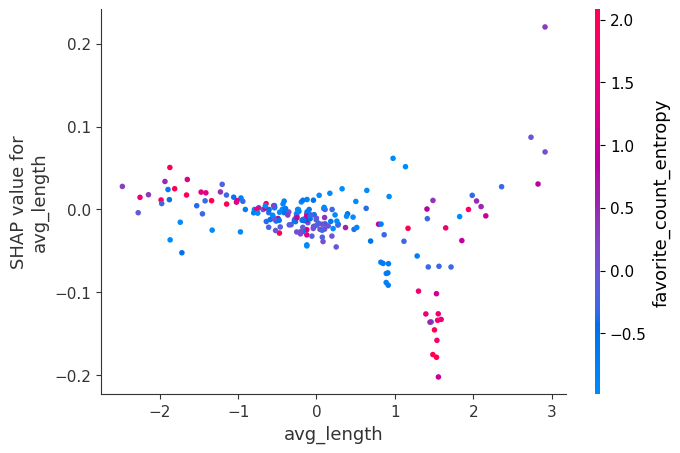

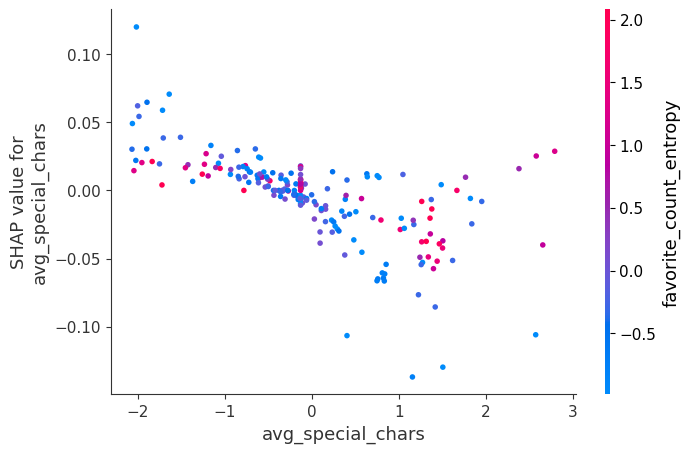

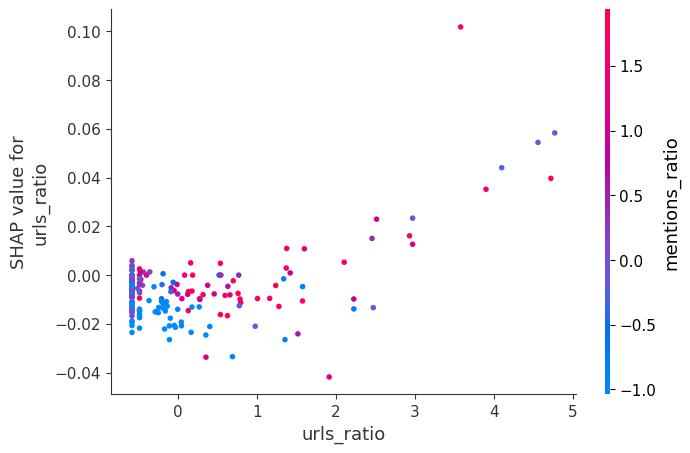

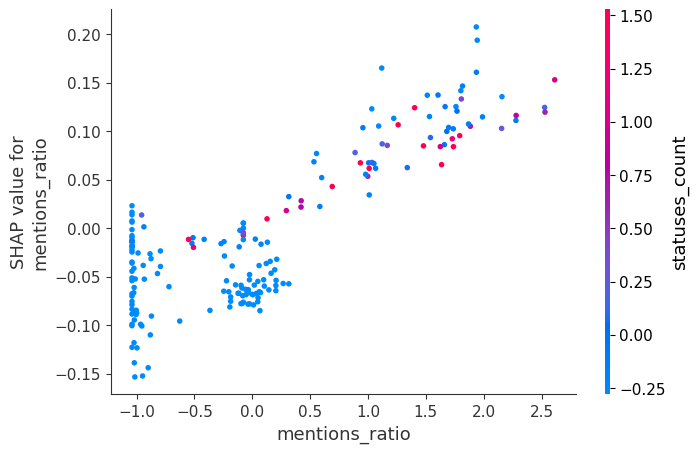

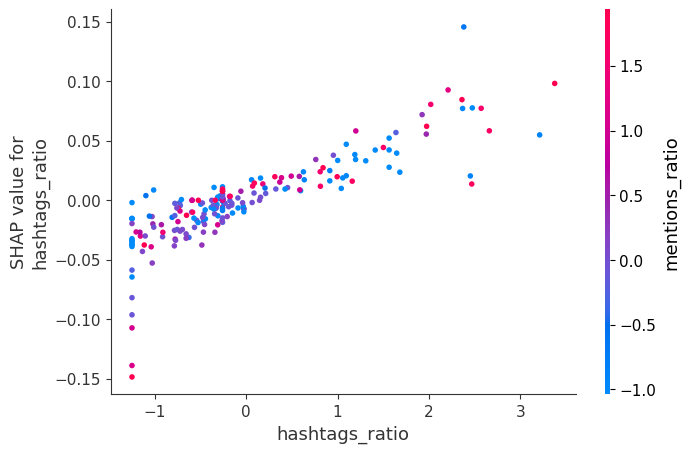

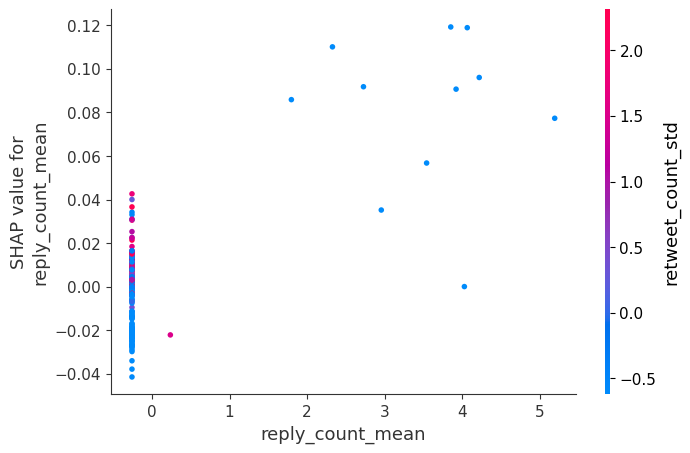

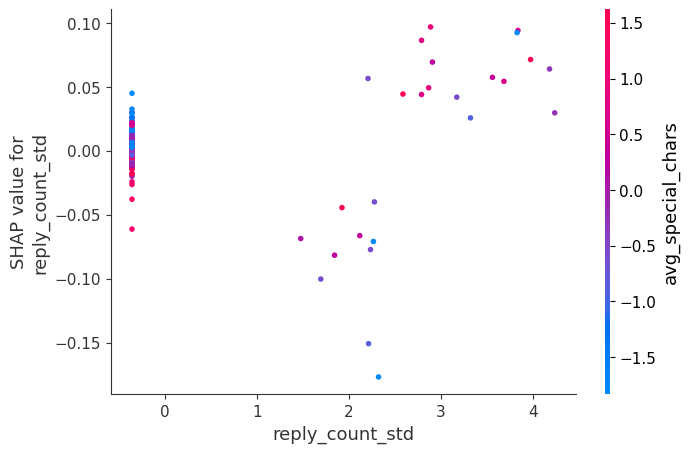

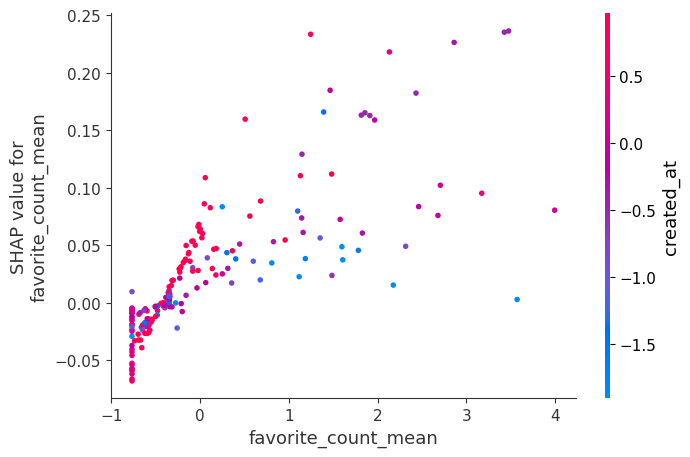

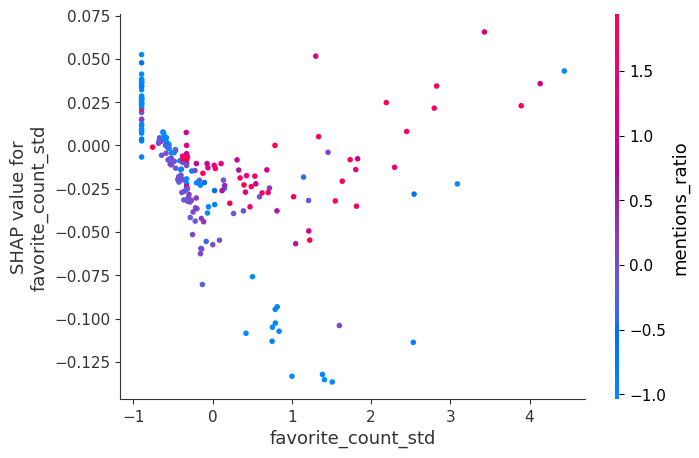

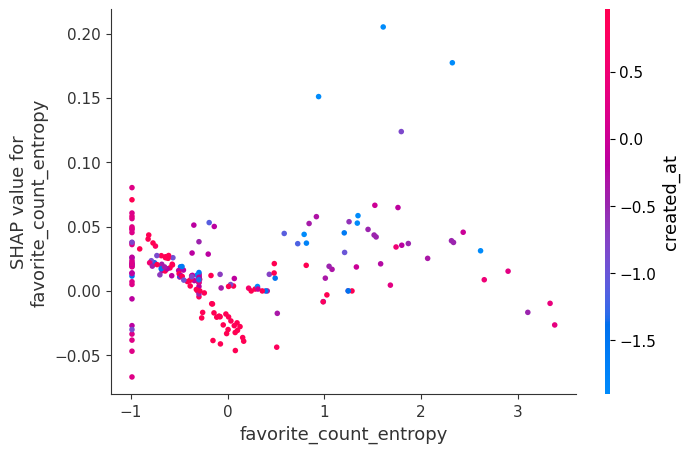

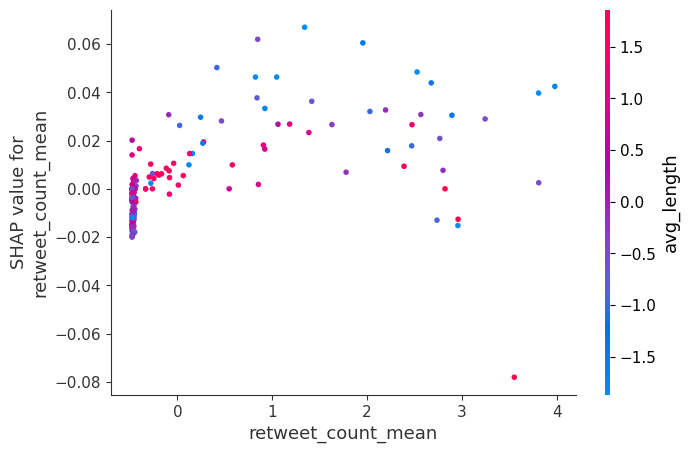

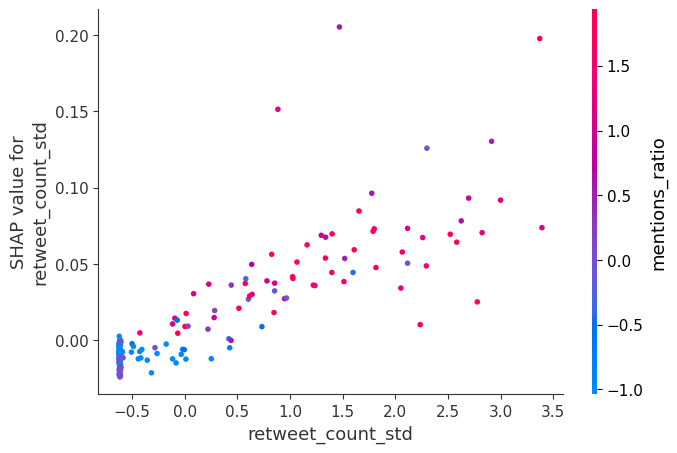

In [16]:
for feat in features:
    shap.dependence_plot(
        feat,
        shap_values[0], test_X[0:200], feature_names=features)

### Local Explain

In [17]:
pd.Series(test_X[12], features)

created_at                0.998142
statuses_count           -0.205524
avg_length                2.042111
avg_special_chars         1.765555
urls_ratio               -0.481862
mentions_ratio           -0.077020
hashtags_ratio           -0.258716
reply_count_mean         -0.259853
reply_count_std          -0.356626
favorite_count_mean       0.680276
favorite_count_std        1.211483
favorite_count_entropy    0.481685
retweet_count_mean       -0.461295
retweet_count_std         2.300155
dtype: float64

In [18]:
nn_model.predict([test_X[12]])

array([0])

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], feature_names=test_set.columns.to_list())

In [20]:
pd.Series(test_X[1], features)

created_at               -0.175436
statuses_count           -0.278546
avg_length               -0.224296
avg_special_chars         0.110206
urls_ratio               -0.577392
mentions_ratio           -1.039438
hashtags_ratio            0.595721
reply_count_mean          1.796747
reply_count_std           1.477616
favorite_count_mean      -0.618921
favorite_count_std       -0.583208
favorite_count_entropy   -0.676538
retweet_count_mean       -0.470920
retweet_count_std        -0.617307
dtype: float64

In [21]:
nn_model.predict([test_X[1]])

array([1])

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], feature_names=test_set.columns.to_list())

## Explain Model: LIME

In [23]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names = features)

In [24]:
exp = lime_explainer.explain_instance(test_X[0], nn_model.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=True)

In [25]:
exp = lime_explainer.explain_instance(test_X[2], nn_model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

## Explain Model: Evaluation

### Lime

In [26]:
exp.local_exp

{1: [(1, 0.40625799945021607),
  (0, -0.1703694235284394),
  (10, -0.06789779671440248),
  (5, 0.03691369011698094),
  (2, 0.027126642167824486),
  (8, 0.022401123479690015),
  (9, 0.02024461146292203),
  (12, 0.01969331547760757),
  (13, 0.018166530651850265),
  (7, 0.017424451598327853)]}

In [27]:
from aix360.metrics import faithfulness_metric, monotonicity_metric

predicted_class = nn_model.predict([test_X[0]])[0]

le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test_X[0]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(nn_model, x, coefs, base))
print("Monotonity: ", monotonicity_metric(nn_model, x, coefs, base))

Faithfulness:  0.9005994106264691
Monotonity:  False


In [28]:
ncases = 100
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(test_X[i], nn_model.predict_proba, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test_set.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(nn_model, test_X[i], coefs, base)
    
fait[np.isnan(fait)] = 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.60it/s]


In [29]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.5465616212101883
Faithfulness metric std. dev.: 0.549724284692997


### Shap

In [30]:
print("Faithfulness: ", faithfulness_metric(nn_model, test_X[1], shap_values[nn_model.predict([test_X[1]])[0]][1], base))
print("Monotonity: ", monotonicity_metric(nn_model, x, shap_values[predicted_class][1], base))

Faithfulness:  0.6051643103169674
Monotonity:  True


In [31]:
ncases = 20 # max shap values istances
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(nn_model, test_X[i], shap_values[predicted_class][i], base)

fait[np.isnan(fait)] = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 428.16it/s]


In [32]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.49939382358026607
Faithfulness metric std. dev.: 0.37832013343846416
